# Модель анализатора фото

In [1]:
import os

dataset_path = "image/"
print(os.listdir(dataset_path))


['alfredo', 'broccoli', 'brownie', 'cake', 'carrot', 'cereal', 'cheese', 'chicken', 'chocolate', 'coffee', 'cookie', 'corn', 'couscous', 'crab', 'donut', 'egg', 'fajitas', 'fries', 'grilledcheese', 'hotdog', 'icecream', 'macncheese', 'nachos', 'nuggets', 'rice', 'salad', 'salmon', 'shrimp', 'soup', 'steak', 'sushi', 'tartare']


## Загружаем изображения

И обрабатываем аугментацией (сдвиги повороты)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
img_height, img_width = 224, 224
batch_size = 32


datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,        # Поворот изображения
    width_shift_range=0.2,    # Сдвиг по ширине
    height_shift_range=0.2,   # Сдвиг по высоте
    shear_range=0.2,          # Искажение (shear)
    zoom_range=0.2,           # Масштабирование
    horizontal_flip=True,     # Отражение по горизонтали
    fill_mode='nearest'       # Заполнение пикселей после трансформации
)

# Пересоздаем генераторы с аугментацией
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)


Found 7609 images belonging to 32 classes.
Found 1881 images belonging to 32 classes.


## Анализ данных 

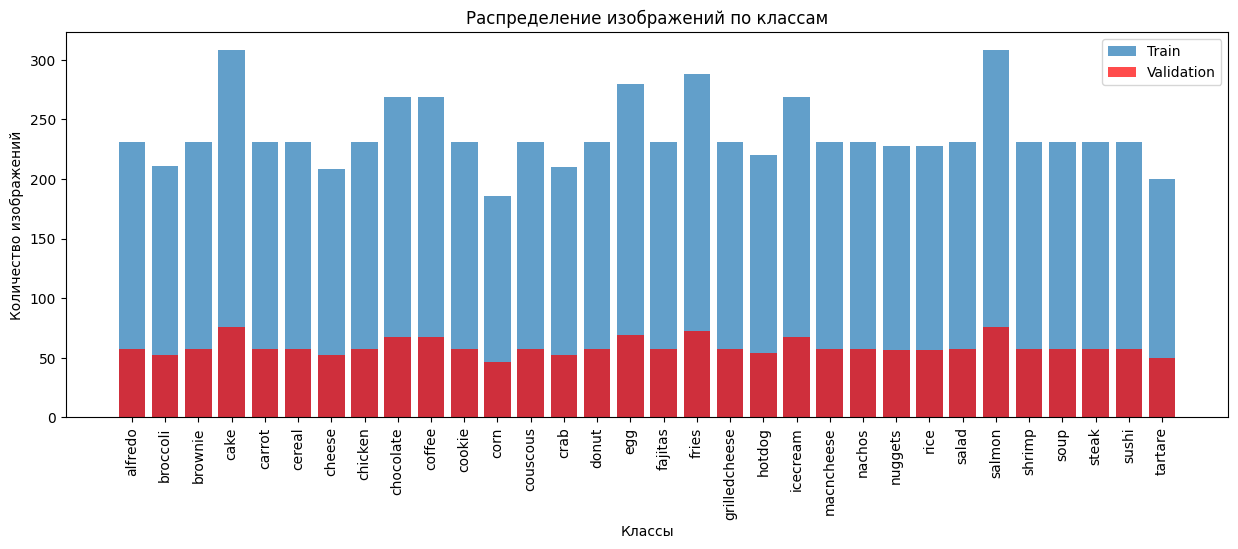

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Получаем список классов
class_labels = list(train_generator.class_indices.keys())

# Считаем количество изображений в каждом классе
train_counts = np.bincount(train_generator.classes)
val_counts = np.bincount(validation_generator.classes)

# Строим график распределения классов
plt.figure(figsize=(15, 5))
plt.bar(class_labels, train_counts, label="Train", alpha=0.7)
plt.bar(class_labels, val_counts, label="Validation", alpha=0.7, color='red')
plt.xticks(rotation=90)
plt.xlabel("Классы")
plt.ylabel("Количество изображений")
plt.title("Распределение изображений по классам")
plt.legend()
plt.show()


## Создаем и обучаем модель

In [ ]:
from tensorflow.keras import layers, models

# Определяем параметры модели
input_shape = (img_height, img_width, 3)
num_classes = len(train_generator.class_indices)

# Определяем архитектуру модели CNN
model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),  # Регуляризация для избежания переобучения
        layers.Dense(num_classes, activation='softmax')  # Классификация на 32 класса
    ])

# Компилируем модель
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Выводим архитектуру модели
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         4,128 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,173,088 (42.62 MB)

 Trainable params: 11,173,088 (42.62 MB)

 Non-trainable params: 0 (0.00 B)

Обучение

In [ ]:
history = model.fit(
    train_generator,
    epochs=10, 
    validation_data=validation_generator
)

Epoch 1/10


c:\Users\Александр\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


238/238 ━━━━━━━━━━━━━━━━━━━━ 241s 993ms/step - accuracy: 0.0845 - loss: 3.4643 - val_accuracy: 0.4402 - val_loss: 1.8712
Epoch 2/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 225s 935ms/step - accuracy: 0.3832 - loss: 1.9473 - val_accuracy: 0.7065 - val_loss: 1.0068
Epoch 3/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 228s 948ms/step - accuracy: 0.5396 - loss: 1.3745 - val_accuracy: 0.7645 - val_loss: 0.7392
Epoch 4/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 223s 926ms/step - accuracy: 0.6110 - loss: 1.1532 - val_accuracy: 0.8006 - val_loss: 0.6378
Epoch 5/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 237s 987ms/step - accuracy: 0.6789 - loss: 0.9222 - val_accuracy: 0.8262 - val_loss: 0.5699
Epoch 6/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 238s 992ms/step - accuracy: 0.6930 - loss: 0.8898 - val_accuracy: 0.8405 - val_loss: 0.4665
Epoch 7/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 239s 995ms/step - accuracy: 0.7426 - loss: 0.7495 - val_accuracy: 0.8607 - val_loss: 0.4460
Epoch 8/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 252s 1s/step - accuracy: 0.7658 - loss: 0.6798 

## Визуализируем процесс обучения

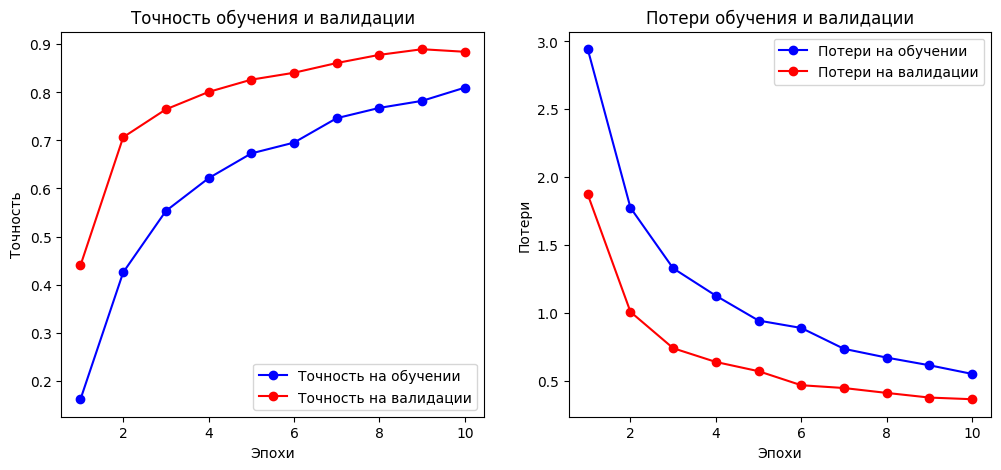

In [9]:
import matplotlib.pyplot as plt


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))

# График точности
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Точность на обучении')
plt.plot(epochs, val_acc, 'ro-', label='Точность на валидации')
plt.xlabel('Эпохи')
plt.ylabel('Точность')
plt.legend()
plt.title('Точность обучения и валидации')

# График потерь
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Потери на обучении')
plt.plot(epochs, val_loss, 'ro-', label='Потери на валидации')
plt.xlabel('Эпохи')
plt.ylabel('Потери')
plt.legend()
plt.title('Потери обучения и валидации')

plt.show()


## Улучшение модели с помощью предобученной сети (Transfer Learning)

In [10]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

# Загружаем предобученную MobileNetV2 (без верхних слоев)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Замораживаем веса базовой модели (чтобы не изменялись при обучении)
base_model.trainable = False

# Добавляем свои слои поверх предобученной модели
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Глобальное усреднение
x = Dense(512, activation='relu')(x)  # Новый полносвязный слой
x = Dropout(0.5)(x)  # Регуляризация
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(num_classes, activation='softmax')(x)  # Выходной слой

# Создаем новую модель
model = Model(inputs=base_model.input, outputs=predictions)

# Компилируем модель
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Выводим архитектуру модели
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 3,053,408 (11.65 MB)

 Trainable params: 795,424 (3.03 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Обучение с transfer learning

In [11]:
# Обучение модели с предобученной сетью
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

Epoch 1/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 269s 1s/step - accuracy: 0.6906 - loss: 1.1848 - val_accuracy: 0.9872 - val_loss: 0.0454
Epoch 2/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 260s 1s/step - accuracy: 0.9781 - loss: 0.0675 - val_accuracy: 0.9936 - val_loss: 0.0187
Epoch 3/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 260s 1s/step - accuracy: 0.9862 - loss: 0.0497 - val_accuracy: 0.9936 - val_loss: 0.0263
Epoch 4/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 260s 1s/step - accuracy: 0.9893 - loss: 0.0332 - val_accuracy: 0.9952 - val_loss: 0.0224
Epoch 5/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 259s 1s/step - accuracy: 0.9858 - loss: 0.0462 - val_accuracy: 0.9942 - val_loss: 0.0165
Epoch 6/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 264s 1s/step - accuracy: 0.9914 - loss: 0.0299 - val_accuracy: 0.9920 - val_loss: 0.0315
Epoch 7/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 276s 1s/step - accuracy: 0.9916 - loss: 0.0274 - val_accuracy: 0.9942 - val_loss: 0.0377
Epoch 8/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 267s 1s/step - accuracy: 0.9905 - loss: 0.0369 - val_accu

## Визуализация дообучения

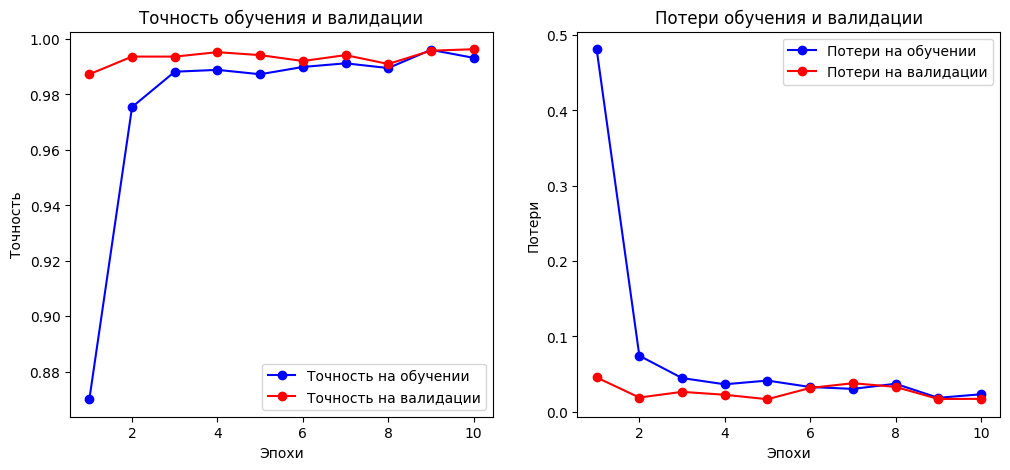

In [12]:
import matplotlib.pyplot as plt


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))

# График точности
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Точность на обучении')
plt.plot(epochs, val_acc, 'ro-', label='Точность на валидации')
plt.xlabel('Эпохи')
plt.ylabel('Точность')
plt.legend()
plt.title('Точность обучения и валидации')

# График потерь
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Потери на обучении')
plt.plot(epochs, val_loss, 'ro-', label='Потери на валидации')
plt.xlabel('Эпохи')
plt.ylabel('Потери')
plt.legend()
plt.title('Потери обучения и валидации')

plt.show()




## Реализация кросс-валидации
Используем K=5 (5-фолдовая кросс-валидация):

In [17]:
from sklearn.model_selection import KFold
import numpy as np

# Параметры кросс-валидации
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True)

# Список для сохранения результатов
fold_accuracies = []

# Генератор данных (используем один набор без разделения train/val)
datagen = ImageDataGenerator(rescale=1./255)
all_data = datagen.flow_from_directory(
    dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

# Разбиваем данные на K частей и обучаем модель на каждой из них
for fold, (train_idx, val_idx) in enumerate(kf.split(all_data)):
    print(f"\n🔹 **Обучение на фолде {fold+1}/{k_folds}**")

    # Создаем новую модель MobileNetV2 для каждого фолда
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
    base_model.trainable = False  # Замораживаем веса

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Обучаем модель
    history = model.fit(
        all_data,
        epochs=5,  # Уменьшаем количество эпох для быстрой проверки
        verbose=1
    )

    # Сохраняем точность для каждого фолда
    final_acc = history.history['accuracy'][-1]
    fold_accuracies.append(final_acc)

# Средняя точность по всем фолдам
mean_acc = np.mean(fold_accuracies)
print(f"\n✅ **Средняя точность на {k_folds}-фолдовой кросс-валидации: {mean_acc:.4f}**")


Found 9490 images belonging to 32 classes.

🔹 **Обучение на фолде 1/5**
Epoch 1/5


c:\Users\Александр\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


297/297 ━━━━━━━━━━━━━━━━━━━━ 281s 917ms/step - accuracy: 0.7186 - loss: 1.0752
Epoch 2/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 269s 899ms/step - accuracy: 0.9844 - loss: 0.0486
Epoch 3/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 269s 898ms/step - accuracy: 0.9850 - loss: 0.0490
Epoch 4/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 265s 886ms/step - accuracy: 0.9866 - loss: 0.0375
Epoch 5/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 247s 821ms/step - accuracy: 0.9883 - loss: 0.0390

🔹 **Обучение на фолде 2/5**
Epoch 1/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 263s 861ms/step - accuracy: 0.7268 - loss: 1.0487
Epoch 2/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 247s 823ms/step - accuracy: 0.9788 - loss: 0.0758
Epoch 3/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 246s 821ms/step - accuracy: 0.9849 - loss: 0.0502
Epoch 4/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 249s 831ms/step - accuracy: 0.9866 - loss: 0.0439
Epoch 5/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 252s 839ms/step - accuracy: 0.9897 - loss: 0.0367

🔹 **Обучение на фолде 3/5**
Epoch 1/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 263s 863ms/step - accur

Информация по фолдам:
Фолд 1: 0.9862
Фолд 2: 0.9907
Фолд 3: 0.9914
Фолд 4: 0.9894
Фолд 5: 0.9864

Средняя точность: 0.9888
Стандартное отклонение: 0.0021
Минимум: 0.9862
Максимум: 0.9914


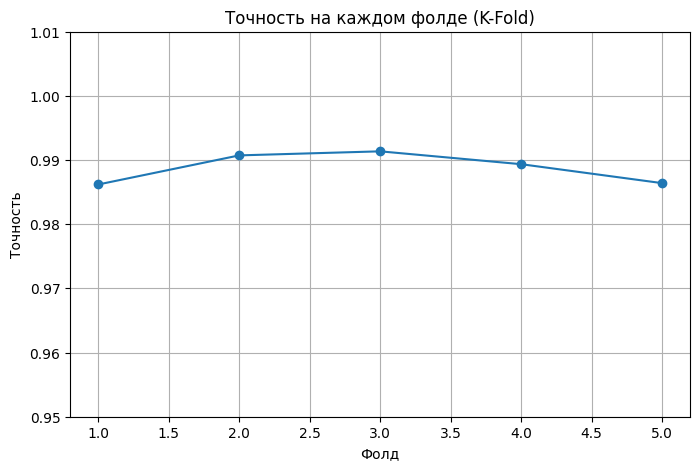

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Расчет статистики
mean_acc = np.mean(fold_accuracies)
std_acc = np.std(fold_accuracies)
min_acc = np.min(fold_accuracies)
max_acc = np.max(fold_accuracies)

print("Информация по фолдам:")
for i, acc in enumerate(fold_accuracies, 1):
    print(f"Фолд {i}: {acc:.4f}")
print(f"\nСредняя точность: {mean_acc:.4f}")
print(f"Стандартное отклонение: {std_acc:.4f}")
print(f"Минимум: {min_acc:.4f}")
print(f"Максимум: {max_acc:.4f}")

# Визуализация
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(fold_accuracies)+1), fold_accuracies, marker='o')
plt.title("Точность на каждом фолде (K-Fold)")
plt.xlabel("Фолд")
plt.ylabel("Точность")
plt.ylim(0.95, 1.01)
plt.grid(True)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 890ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 811ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 820ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 842ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 785ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 802ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 795ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 826ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 784ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 797ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 764ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 845ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 776ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 816ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 849ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 805ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 802ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 835ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 752ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 747ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 801ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 903ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 856ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 818ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

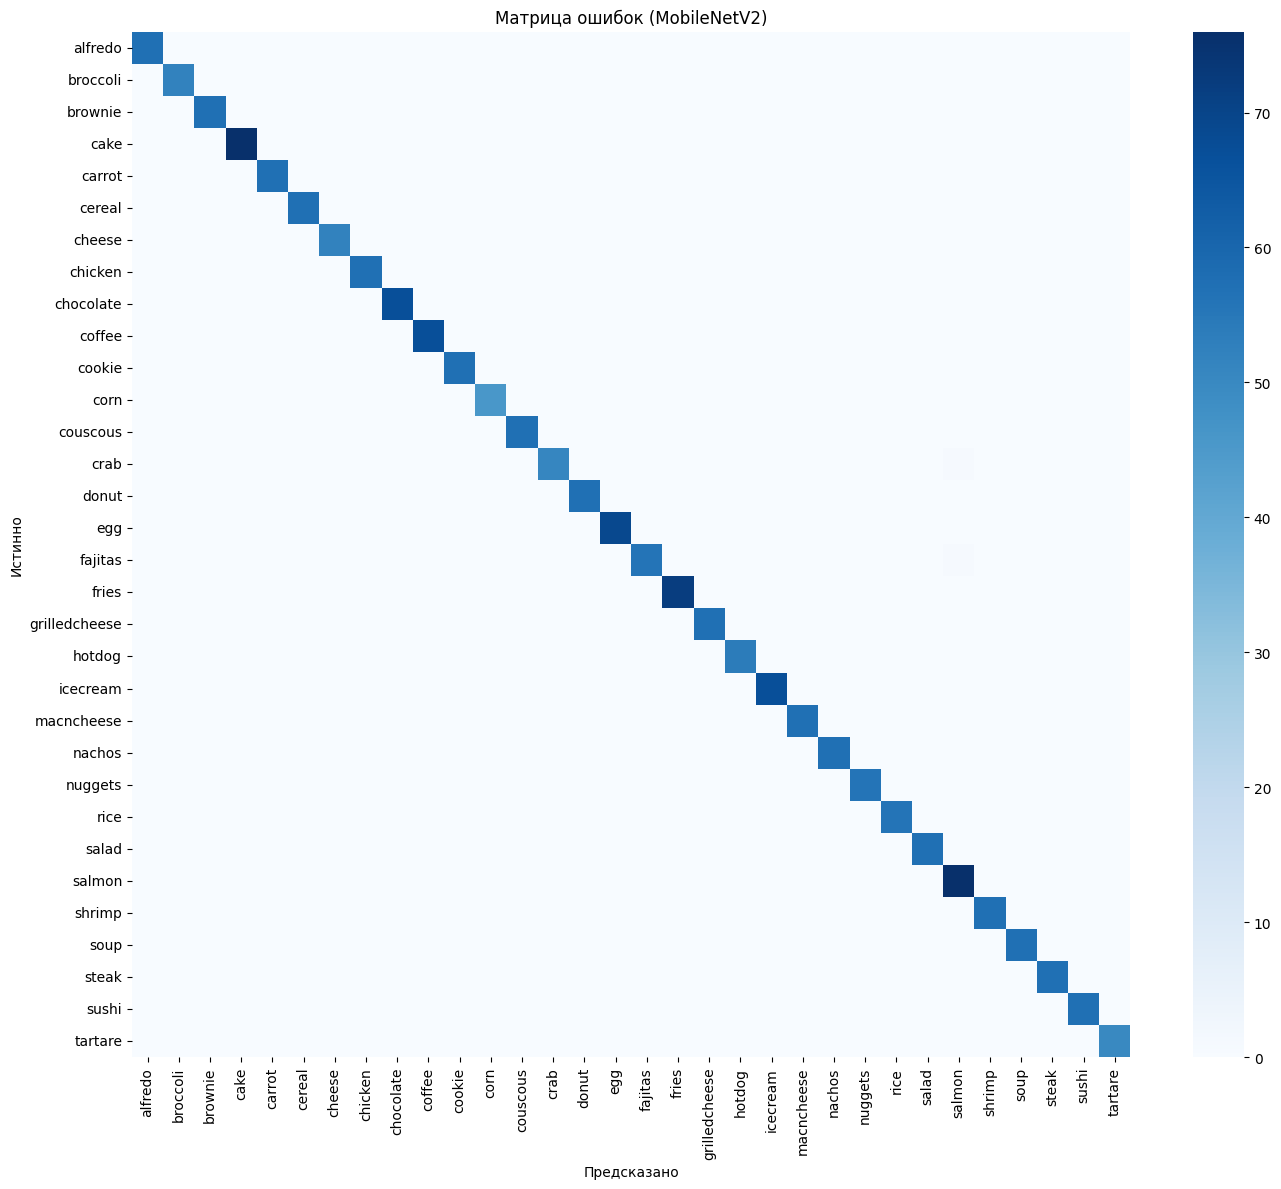

               precision    recall  f1-score   support

      alfredo       1.00      1.00      1.00        57
     broccoli       1.00      1.00      1.00        52
      brownie       1.00      1.00      1.00        57
         cake       1.00      1.00      1.00        76
       carrot       1.00      1.00      1.00        57
       cereal       1.00      1.00      1.00        57
       cheese       1.00      1.00      1.00        52
      chicken       1.00      1.00      1.00        57
    chocolate       1.00      1.00      1.00        67
       coffee       1.00      1.00      1.00        67
       cookie       1.00      1.00      1.00        57
         corn       1.00      1.00      1.00        46
     couscous       1.00      1.00      1.00        57
         crab       1.00      0.98      0.99        52
        donut       1.00      1.00      1.00        57
          egg       1.00      1.00      1.00        69
      fajitas       1.00      0.98      0.99        57
        f

In [24]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


y_true = []
y_pred = []
class_labels = list(train_generator.class_indices.keys())

# Сброс генератора
validation_generator.reset()

# Предсказание по всем батчам
for i in range(len(validation_generator)):
    x_batch, y_batch = next(validation_generator)
    preds = model.predict(x_batch)
    y_true.extend(np.argmax(y_batch, axis=1))
    y_pred.extend(np.argmax(preds, axis=1))
    if i >= validation_generator.samples // validation_generator.batch_size:
        break

# Матрица ошибок
cm = confusion_matrix(y_true, y_pred)

# Визуализация
plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel('Предсказано')
plt.ylabel('Истинно')
plt.title('Матрица ошибок (MobileNetV2)')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Отчет по классам
print(classification_report(y_true, y_pred, target_names=class_labels))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 774ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 771ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 753ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 736ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 750ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 737ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 751ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 736ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 726ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 752ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 736ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 756ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 774ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 803ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 773ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

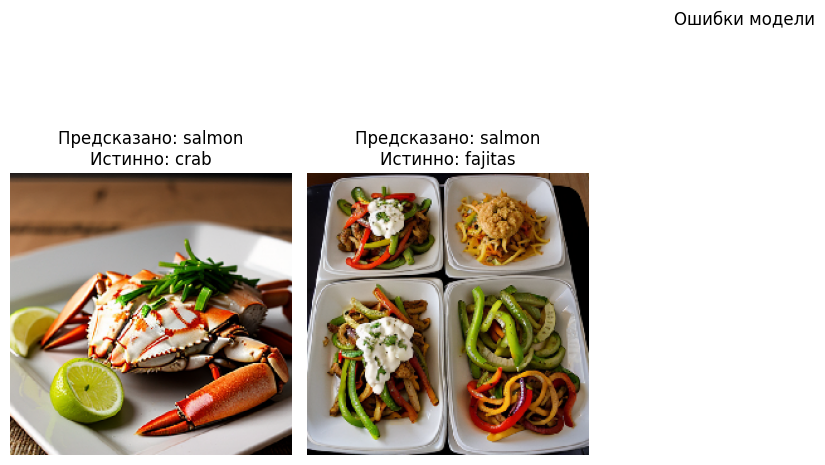

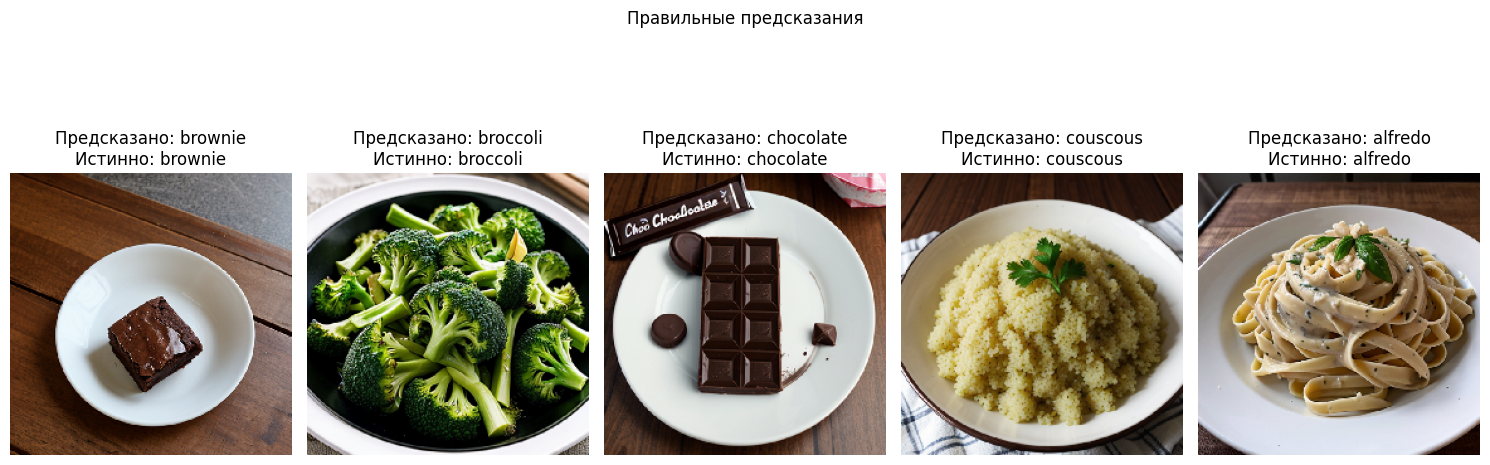

In [20]:
import matplotlib.pyplot as plt

# Количество примеров
num_images_to_show = 5

# Обнуляем
validation_generator.reset()
y_true = []
y_pred = []
images = []

# Получаем батчи и сохраняем изображения
for i in range(len(validation_generator)):
    x_batch, y_batch = next(validation_generator)
    preds = model.predict(x_batch)
    y_true.extend(np.argmax(y_batch, axis=1))
    y_pred.extend(np.argmax(preds, axis=1))
    images.extend(x_batch)
    if len(y_true) >= validation_generator.samples:
        break

# Переводим в массивы
y_true = np.array(y_true)
y_pred = np.array(y_pred)
images = np.array(images)
class_labels = list(validation_generator.class_indices.keys())

# Найдем ошибки
error_indices = np.where(y_true != y_pred)[0]
correct_indices = np.where(y_true == y_pred)[0]

# Функция отображения
def show_images(indices, title):
    plt.figure(figsize=(15, 6))
    for i, idx in enumerate(indices[:num_images_to_show]):
        plt.subplot(1, num_images_to_show, i + 1)
        plt.imshow(images[idx])
        plt.axis('off')
        plt.title(f"Предсказано: {class_labels[y_pred[idx]]}\nИстинно: {class_labels[y_true[idx]]}")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Покажем ошибки
show_images(error_indices, "Ошибки модели")

# Покажем правильные предсказания
show_images(correct_indices, "Правильные предсказания")


Сохраняем модель

In [22]:
# Сохраняем модель как .h5
model.save("content/food_classifier_model.h5")


# Вторая модель

## Загрузка первой модели в переменную

In [27]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model

# Загружаем модель
model = load_model('content/food_classifier_model.h5')
img_height, img_width = 224, 224

## Функции, которые работают с первой моделью

In [ ]:
import os
import random

# Разбираем папки в image на классы
def get_class_labels():
    classes_dir = os.path.join('image')
    return sorted([d for d in os.listdir(classes_dir) 
                 if os.path.isdir(os.path.join(classes_dir, d))])

# Пытаемся сделать рандомный выбор
def get_random_photo():
    root_folder = "image"
    class_folders = [d for d in os.listdir(root_folder) if os.path.isdir(os.path.join(root_folder, d))]
    random_class = random.choice(class_folders)
    class_path = os.path.join(root_folder, random_class)
    image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif'))]
    random_image = random.choice(image_files)
    img_path = os.path.join(class_path, random_image)
    # print(f"Класс: {random_class}")
    # print(f"Файл: {random_image}")
    # print(f"Полный путь: {img_path}")
    return img_path

# Предсказание класса по изображению
def predict_class(model, img_path):
    # Получаем метки классов из структуры датасета
    class_labels = get_class_labels()
    # print(class_labels)
    
    # Загрузка и обработка изображения
    img = tf.keras.utils.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0
    pred = model.predict(img_array)
    return class_labels[np.argmax(pred)] #, np.max(pred) # Возвращаем предсказанное блюдо и вероятность "правильности"



# Проверка
predicted_label = predict_class(model, get_random_photo())

print(f"Предсказанное блюдо: {predicted_label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Предсказанное блюдо: cheese


## Зависимости

In [57]:
!pip install -q huggingface_hub
!pip install transformers accelerate



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: C:\Program Files\Python313\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: C:\Program Files\Python313\python.exe -m pip install --upgrade pip


## Вход и установка

In [ ]:
from huggingface_hub import login
login(token="token")

In [38]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
model_id = "mistralai/Mistral-7B-Instruct-v0.2"

tokenizer = AutoTokenizer.from_pretrained(model_id)
model_neo = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",            # Использует GPU, если доступен
    torch_dtype=torch.float16     # Используй float32, если нет GPU
)

c:\Users\Александр\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Александр\.cache\huggingface\hub\models--mistralai--Mistral-7B-Instruct-v0.2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Loading checkpoint shards: 100%|██████████| 3/3 [00:08<00:00,  2.84s/it

## Функции для работы второй модели

In [ ]:
def get_prompt(dish_name):
    return f"[INST] Ты диетолог. Оцени, сколько калорий примерно содержит блюдо '{dish_name}'. Укажи калорийность и кратко прокомментируй, подходит ли оно для сбалансированного питания. [/INST]"

# Токенизация с перемещением на устройство модели
def get_answer_from_neo(prompt):
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(model_neo.device)

    # Генерация текста
    output = model_neo.generate(
        input_ids,
        do_sample=True,
        temperature=0.7,
        max_new_tokens=100,  
        pad_token_id=tokenizer.eos_token_id,
        top_p = 0.85,
        repetition_penalty=1.1,
        no_repeat_ngram_size=3
    )

    # Декодируем только сгенерированную часть (исключая промпт)
    generated_text = tokenizer.decode(output[0][input_ids.shape[1]:], skip_special_tokens=True)

    return generated_text

## Ответ модели

In [40]:
# проверка
print("Ответ нео:\n" )
promt = get_prompt(predict_class(model,get_random_photo()))
print(promt)
print(get_answer_from_neo(promt))

Ответ нео:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step
[INST] Ты диетолог. Оцени, сколько калорий примерно содержит блюдо 'couscous'. Укажи калорийность и кратко прокомментируй, подходит ли оно для сбалансированного питания. [/INST]
As a dietitian, I'd be happy to help you estimate the calorie content of couscous. One cup (cooked) of plain couscouse contains approximately 205 calories. Couscouse is primarily made from durum wheat semolina and water, so most of its calories come from complex carbohydrates.

Couscouses can be an excellent addition to a balanced diet due to its versatility, as it can be
